# Missing value imputation: RandomSampleImputer

Examples on how to use the missing values imputers available in Feature-engine.

**For this demonstration, we use the Ames House Prices dataset produced by Professor Dean De Cock:**

Dean De Cock (2011) Ames, Iowa: Alternative to the Boston Housing
Data as an End of Semester Regression Project, Journal of Statistics Education, Vol.19, No. 3

http://jse.amstat.org/v19n3/decock.pdf

https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627

The version of the dataset used in this notebook can be obtained from [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)


The RandomSampleImputer works for both categorical and numerical variables. It will extract a random sample from the observations where data is available, and use it to replace the NA.


When no variable list is passed, it will default to all variables in the dataset.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import feature_engine.imputation as mdi

In [2]:
import feature_engine 
feature_engine.__version__

'1.0.0'

In [3]:
data = pd.read_csv('houseprice.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Id', 'SalePrice'], axis=1), data['SalePrice'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((1022, 79), (438, 79))

In [5]:
# note that the imputer has a random_state option for reproducibility
# more on the seed for the imputer in the documentation

random_imputer = mdi.RandomSampleImputer(
    variables=['Alley', 'MasVnrType', 'LotFrontage', 'MasVnrArea'],
    random_state=10)

random_imputer.fit(X_train)

RandomSampleImputer(random_state=10,
                    variables=['Alley', 'MasVnrType', 'LotFrontage',
                               'MasVnrArea'])

In [6]:
# the imputer saves a copy of the variables from the training set to impute new data

random_imputer.X_.head()

,Alley,MasVnrType,LotFrontage,MasVnrArea
64,NaN,BrkFace,NaN,573.0
682,NaN,None,NaN,0.0
960,NaN,None,50.0,0.0
1384,NaN,None,60.0,0.0
1100,NaN,None,60.0,0.0


In [9]:
X_train[['Alley', 'MasVnrType', 'LotFrontage', 'MasVnrArea']].isnull().mean()

Alley          0.939335
MasVnrType     0.004892
LotFrontage    0.184932
MasVnrArea     0.004892
dtype: float64

In [10]:
train_t = random_imputer.transform(X_train)
test_t = random_imputer.transform(X_test)

In [11]:
train_t[['Alley', 'MasVnrType', 'LotFrontage', 'MasVnrArea']].isnull().mean()

Alley          0.0
MasVnrType     0.0
LotFrontage    0.0
MasVnrArea     0.0
dtype: float64

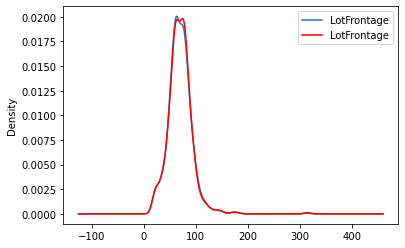

In [12]:
# when using the random sample imputer, the distribution of the variable does not change

fig = plt.figure()
ax = fig.add_subplot(111)
X_train['LotFrontage'].plot(kind='kde', ax=ax)
train_t['LotFrontage'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

### Setting a seed on variables, at observation level

In [14]:
imputer_obs = mdi.RandomSampleImputer(random_state=['MSSubClass', 'YrSold'],
                                  seed='observation',
                                  seeding_method='add')

imputer_obs.fit(X_train)

RandomSampleImputer(random_state=['MSSubClass', 'YrSold'], seed='observation',
                    variables=['MSSubClass', 'MSZoning', 'LotFrontage',
                               'LotArea', 'Street', 'Alley', 'LotShape',
                               'LandContour', 'Utilities', 'LotConfig',
                               'LandSlope', 'Neighborhood', 'Condition1',
                               'Condition2', 'BldgType', 'HouseStyle',
                               'OverallQual', 'OverallCond', 'YearBuilt',
                               'YearRemodAdd', 'RoofStyle', 'RoofMatl',
                               'Exterior1st', 'Exterior2nd', 'MasVnrType',
                               'MasVnrArea', 'ExterQual', 'ExterCond',
                               'Foundation', 'BsmtQual', ...])

In [15]:
train_t = random_imputer.transform(X_train)
test_t = random_imputer.transform(X_test)

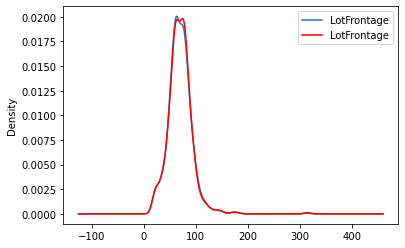

In [16]:
# when using the random sample imputer, the distribution of the variable does not change

fig = plt.figure()
ax = fig.add_subplot(111)
X_train['LotFrontage'].plot(kind='kde', ax=ax)
train_t['LotFrontage'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')